In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import invwishart
import os
from ML_util import trainNN

N = 10000;
df_fac = 2;

Ds = np.concatenate((np.array([2]), np.arange(5,101,5)), axis=0);
print(Ds);
num_Ds = Ds.shape[0];

[  2   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100]


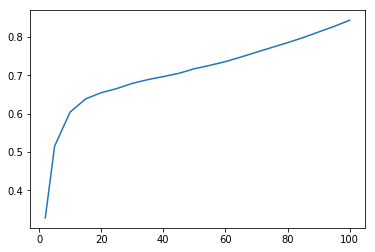

In [2]:
# determine linear regression trend
savefile = 'lingauss_reg.npz';

do_compute = True;
if (os.path.exists(savefile)):
    file = np.load(savefile);
    if 'LR_R2s' in file:
        LR_R2s = file['LR_R2s'];
        do_compute = False;

if (do_compute):
    LR_R2s = np.zeros((num_Ds,));
    for i in range(num_Ds):
        D = Ds[i];

        df = df_fac*D;
        scale = df_fac*np.eye(D);
        dist = invwishart(df, scale);
        covs = dist.rvs(N);
        chols = np.zeros((N,D,D));
        eta2 = np.zeros((N,D,D));
        for j in range(N):
            chols[j] = np.linalg.cholesky(covs[j]);
            eta2[j] = -(0.5)*np.linalg.inv(covs[j]);

        y = np.reshape(chols, (N,D*D));
        x = np.reshape(eta2, (N,D*D));
        y_mean = np.expand_dims(np.mean(y, 0), 0);

        cov_mask = np.tril(np.ones((D,D), dtype=np.bool_), 0);
        y_trim = np.reshape(chols[:,cov_mask], (N, int(D*(D+1)/2)));
        x_trim = np.reshape(eta2[:,cov_mask], (N, int(D*(D+1)/2)));
        y_trim_mean = np.expand_dims(np.mean(y_trim, 0), 0);

        # show linear regression performance
        X = np.concatenate((np.ones((N,1)), x_trim), axis=1);
        dotprod = np.dot(X.T, X);
        beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y_trim);
        y_rec = np.dot(X, beta);
        residuals = y_trim-y_rec;
        RSS = np.sum(np.square(residuals));
        TSS = np.sum(np.square(y_trim-y_trim_mean));
        R2 = 1.0 - (RSS/TSS);
        print(D, R2);
        LR_R2s[i] = R2;
    np.savez(savefile, LR_R2s=LR_R2s);
plt.figure();
plt.plot(Ds, LR_R2s);
plt.show();

In [25]:
# determine linear regression trend
D = 3;
act_str = 'tanh';
if (act_str == 'tanh'):
    activation = tf.nn.tanh;
elif (act_str == 'relu'):
    activation = tf.nn.relu;

savefile = 'lingauss_nn_D=%d_%s.npz' % (D, act_str);
Ls = np.arange(1,5);
units_per_layers = np.arange(1,5)*(D**2);
do_compute = True;
if (os.path.exists(savefile)):
    file = np.load(savefile);
    do_compute = False;
    
num_Ls = Ls.shape[0];
num_upls = units_per_layers.shape[0]
if (do_compute):
    NN_train_R2s = np.zeros((num_Ls, num_upls));
    NN_test_R2s = np.zeros((num_Ls, num_upls));
    # draw normal distribution parameters mu and Sigma
    mus = np.random.multivariate_normal(np.zeros((D,)), np.eye(D), N);
    print('mu shape', mus.shape);
    df = df_fac*D;
    scale = df_fac*np.eye(D);
    dist = invwishart(df, scale);
    covs = dist.rvs(N);
    # compute the target cholesky factorization and etas
    chols = np.zeros((N,D,D));
    eta1 = np.zeros((N,D,1));
    eta2 = np.zeros((N,D,D));
    for j in range(N):
        chols[j] = np.linalg.cholesky(covs[j]);
        Sigma_inv = np.linalg.inv(covs[j]);
        mu_j = np.expand_dims(mus[j,:], 1);
        eta1[j] = np.dot(Sigma_inv, mu_j)
        eta2[j] = -(0.5)*Sigma_inv;

    y = np.reshape(chols, (N,D*D));
    x = np.reshape(eta2, (N,D*D));
    y_mean = np.expand_dims(np.mean(y, 0), 0);

    cov_mask = np.tril(np.ones((D,D), dtype=np.bool_), 0);
    y_trim = np.reshape(chols[:,cov_mask], (N, int(D*(D+1)/2)));
    x_trim = np.reshape(eta2[:,cov_mask], (N, int(D*(D+1)/2)));
    D_x = x.shape[1];
    for i in range(num_Ls):
        L = Ls[i];
        for j in range(num_upls):
            units_per_layer = units_per_layers[j];
            print('D=%d, L=%d, upl=%d' % (D, L, units_per_layer));
            # show linear regression perfo(rmance
            train_R2, test_R2 = trainNN(y_trim, x_trim, L, units_per_layer, activation, 1e-2, 10000);
            NN_train_R2s[i,j] = train_R2;
            NN_test_R2s[i,j] = test_R2;
    np.savez(savefile, NN_train_R2s=NN_train_R2s, NN_test_R2s=NN_test_R2s);

mu shape (10000, 3)
D=3, L=1, upl=9
making layer 1
pre training R2: -1.191
0: train R2=-1.191, test R2=-0.895
100: train R2=0.680, test R2=0.675
200: train R2=0.725, test R2=0.719
300: train R2=0.752, test R2=0.747
400: train R2=0.779, test R2=0.775
500: train R2=0.799, test R2=0.796
600: train R2=0.809, test R2=0.806
700: train R2=0.815, test R2=0.812
800: train R2=0.818, test R2=0.815
900: train R2=0.821, test R2=0.818
1000: train R2=0.824, test R2=0.822
1100: train R2=0.827, test R2=0.825
1200: train R2=0.830, test R2=0.828
1300: train R2=0.833, test R2=0.830
1400: train R2=0.835, test R2=0.833
1500: train R2=0.837, test R2=0.835
1600: train R2=0.839, test R2=0.837
1700: train R2=0.841, test R2=0.839
1800: train R2=0.843, test R2=0.841
1900: train R2=0.844, test R2=0.842
2000: train R2=0.845, test R2=0.844
2100: train R2=0.846, test R2=0.845
2200: train R2=0.847, test R2=0.846
2300: train R2=0.848, test R2=0.847
2400: train R2=0.849, test R2=0.848
2500: train R2=0.849, test R2=0.848

2300: train R2=0.932, test R2=0.922
2400: train R2=0.933, test R2=0.922
2500: train R2=0.933, test R2=0.923
2600: train R2=0.934, test R2=0.923
2700: train R2=0.934, test R2=0.923
2800: train R2=0.935, test R2=0.923
2900: train R2=0.935, test R2=0.923
3000: train R2=0.935, test R2=0.923
3100: train R2=0.936, test R2=0.923
3200: train R2=0.936, test R2=0.924
3300: train R2=0.937, test R2=0.924
3400: train R2=0.937, test R2=0.924
3500: train R2=0.937, test R2=0.924
3600: train R2=0.938, test R2=0.925
3700: train R2=0.938, test R2=0.925
3800: train R2=0.939, test R2=0.925
3900: train R2=0.939, test R2=0.926
4000: train R2=0.939, test R2=0.926
4100: train R2=0.940, test R2=0.926
4200: train R2=0.940, test R2=0.926
4300: train R2=0.940, test R2=0.927
4400: train R2=0.941, test R2=0.927
4500: train R2=0.941, test R2=0.927
4600: train R2=0.941, test R2=0.927
4700: train R2=0.941, test R2=0.927
4800: train R2=0.941, test R2=0.927
4900: train R2=0.941, test R2=0.927
5000: train R2=0.941, test R

4900: train R2=0.912, test R2=0.904
5000: train R2=0.913, test R2=0.905
5100: train R2=0.913, test R2=0.905
5200: train R2=0.913, test R2=0.906
5300: train R2=0.913, test R2=0.906
5400: train R2=0.914, test R2=0.906
5500: train R2=0.914, test R2=0.906
5600: train R2=0.914, test R2=0.906
5700: train R2=0.914, test R2=0.906
5800: train R2=0.915, test R2=0.906
5900: train R2=0.915, test R2=0.906
6000: train R2=0.914, test R2=0.906
6100: train R2=0.916, test R2=0.907
6200: train R2=0.916, test R2=0.906
6300: train R2=0.916, test R2=0.907
6400: train R2=0.916, test R2=0.907
6500: train R2=0.914, test R2=0.907
6600: train R2=0.916, test R2=0.906
6700: train R2=0.916, test R2=0.907
6800: train R2=0.917, test R2=0.907
6900: train R2=0.916, test R2=0.906
7000: train R2=0.917, test R2=0.907
7100: train R2=0.917, test R2=0.907
7200: train R2=0.917, test R2=0.907
7300: train R2=0.917, test R2=0.906
7400: train R2=0.917, test R2=0.907
7500: train R2=0.917, test R2=0.907
7600: train R2=0.917, test R

7300: train R2=0.989, test R2=0.962
7400: train R2=0.989, test R2=0.962
7500: train R2=0.989, test R2=0.962
7600: train R2=0.989, test R2=0.962
7700: train R2=0.989, test R2=0.962
7800: train R2=0.989, test R2=0.963
7900: train R2=0.989, test R2=0.962
8000: train R2=0.989, test R2=0.963
8100: train R2=0.989, test R2=0.960
8200: train R2=0.989, test R2=0.963
8300: train R2=0.990, test R2=0.963
8400: train R2=0.990, test R2=0.963
8500: train R2=0.990, test R2=0.963
8600: train R2=0.990, test R2=0.963
8700: train R2=0.987, test R2=0.960
8800: train R2=0.984, test R2=0.959
8900: train R2=0.990, test R2=0.963
9000: train R2=0.989, test R2=0.963
9100: train R2=0.980, test R2=0.949
9200: train R2=0.989, test R2=0.962
9300: train R2=0.990, test R2=0.963
9400: train R2=0.988, test R2=0.962
9500: train R2=0.990, test R2=0.963
9600: train R2=0.987, test R2=0.962
9700: train R2=0.988, test R2=0.963
9800: train R2=0.990, test R2=0.964
9900: train R2=0.989, test R2=0.963
finished
D=3, L=2, upl=36
ma

9700: train R2=0.943, test R2=0.931
9800: train R2=0.945, test R2=0.932
9900: train R2=0.946, test R2=0.932
finished
D=3, L=3, upl=18
making layer 1
making layer 2
making layer 3
pre training R2: -1.645
0: train R2=-1.645, test R2=-0.705
100: train R2=0.807, test R2=0.810
200: train R2=0.882, test R2=0.882
300: train R2=0.909, test R2=0.906
400: train R2=0.924, test R2=0.919
500: train R2=0.937, test R2=0.929
600: train R2=0.946, test R2=0.936
700: train R2=0.952, test R2=0.940
800: train R2=0.957, test R2=0.943
900: train R2=0.961, test R2=0.944
1000: train R2=0.964, test R2=0.947
1100: train R2=0.963, test R2=0.946
1200: train R2=0.968, test R2=0.949
1300: train R2=0.970, test R2=0.950
1400: train R2=0.971, test R2=0.951
1500: train R2=0.972, test R2=0.951
1600: train R2=0.973, test R2=0.953
1700: train R2=0.974, test R2=0.954
1800: train R2=0.975, test R2=0.954
1900: train R2=0.976, test R2=0.954
2000: train R2=0.977, test R2=0.956
2100: train R2=0.978, test R2=0.956
2200: train R2=

1800: train R2=0.989, test R2=0.966
1900: train R2=0.993, test R2=0.971
2000: train R2=0.991, test R2=0.967
2100: train R2=0.995, test R2=0.972
2200: train R2=0.995, test R2=0.973
2300: train R2=0.995, test R2=0.973
2400: train R2=0.991, test R2=0.969
2500: train R2=0.993, test R2=0.973
2600: train R2=0.995, test R2=0.974
2700: train R2=0.996, test R2=0.974
2800: train R2=0.995, test R2=0.974
2900: train R2=0.995, test R2=0.974
3000: train R2=0.992, test R2=0.971
3100: train R2=0.996, test R2=0.976
3200: train R2=0.995, test R2=0.974
3300: train R2=0.996, test R2=0.976
3400: train R2=0.996, test R2=0.975
3500: train R2=0.996, test R2=0.975
3600: train R2=0.995, test R2=0.976
3700: train R2=0.996, test R2=0.976
3800: train R2=0.997, test R2=0.977
3900: train R2=0.996, test R2=0.977
4000: train R2=0.996, test R2=0.977
4100: train R2=0.993, test R2=0.974
4200: train R2=0.997, test R2=0.977
4300: train R2=0.997, test R2=0.977
4400: train R2=0.996, test R2=0.976
4500: train R2=0.996, test R

4100: train R2=0.989, test R2=0.968
4200: train R2=0.989, test R2=0.970
4300: train R2=0.989, test R2=0.971
4400: train R2=0.991, test R2=0.972
4500: train R2=0.991, test R2=0.971
4600: train R2=0.991, test R2=0.973
4700: train R2=0.986, test R2=0.968
4800: train R2=0.991, test R2=0.972
4900: train R2=0.990, test R2=0.972
5000: train R2=0.992, test R2=0.973
5100: train R2=0.993, test R2=0.974
5200: train R2=0.993, test R2=0.975
5300: train R2=0.991, test R2=0.973
5400: train R2=0.992, test R2=0.974
5500: train R2=0.993, test R2=0.974
5600: train R2=0.991, test R2=0.973
5700: train R2=0.991, test R2=0.972
5800: train R2=0.990, test R2=0.971
5900: train R2=0.992, test R2=0.973
6000: train R2=0.994, test R2=0.976
6100: train R2=0.993, test R2=0.974
6200: train R2=0.994, test R2=0.976
6300: train R2=0.994, test R2=0.975
6400: train R2=0.992, test R2=0.974
6500: train R2=0.992, test R2=0.973
6600: train R2=0.993, test R2=0.976
6700: train R2=0.993, test R2=0.975
6800: train R2=0.994, test R

6400: train R2=0.998, test R2=0.980
6500: train R2=0.996, test R2=0.979
6600: train R2=0.998, test R2=0.980
6700: train R2=0.997, test R2=0.979
6800: train R2=0.996, test R2=0.979
6900: train R2=0.998, test R2=0.981
7000: train R2=0.998, test R2=0.981
7100: train R2=0.996, test R2=0.980
7200: train R2=0.998, test R2=0.981
7300: train R2=0.996, test R2=0.976
7400: train R2=0.995, test R2=0.978
7500: train R2=0.998, test R2=0.980
7600: train R2=0.994, test R2=0.976
7700: train R2=0.998, test R2=0.980
7800: train R2=0.995, test R2=0.979
7900: train R2=0.997, test R2=0.980
8000: train R2=0.994, test R2=0.976
8100: train R2=0.997, test R2=0.980
8200: train R2=0.998, test R2=0.982
8300: train R2=0.994, test R2=0.979
8400: train R2=0.997, test R2=0.979
8500: train R2=0.998, test R2=0.981
8600: train R2=0.998, test R2=0.980
8700: train R2=0.996, test R2=0.979
8800: train R2=0.998, test R2=0.981
8900: train R2=0.997, test R2=0.980
9000: train R2=0.998, test R2=0.981
9100: train R2=0.998, test R

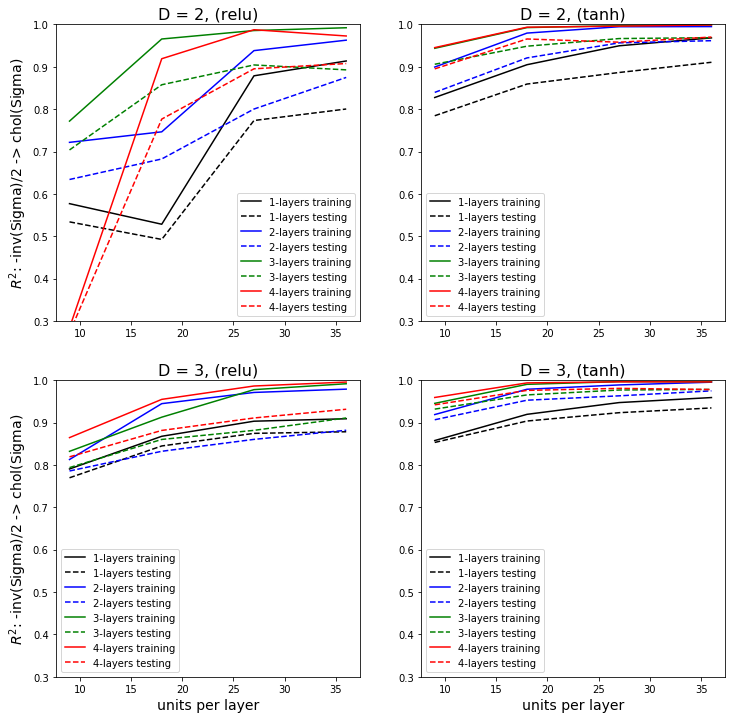

In [34]:
Ds = [2,3];
num_Ds = len(Ds);
act_strs = ['relu', 'tanh'];
num_act_strs = len(act_strs);
fontsize = 14;

fig = plt.figure(figsize=(12,12));
for i in range(num_Ds):
    D = Ds[i];
    for j in range(num_act_strs):
        act_str = act_strs[j];
        savefile = 'lingauss_nn_D=%d_%s.npz' % (D, act_str);
        file = np.load(savefile);
        NN_train_R2s = file['NN_train_R2s'];
        NN_test_R2s = file['NN_test_R2s'];
        fig.add_subplot(num_Ds, num_act_strs, i*num_act_strs+j+1);
        legendstrs = [];
        colorstrs = ['k', 'b', 'g', 'r'];
        for k in range(num_Ls):
            L = Ls[k];
            plt.plot(units_per_layers, NN_train_R2s[k,:], colorstrs[k]);
            legendstrs.append('%d-layers training' % L);
            plt.plot(units_per_layers, NN_test_R2s[k,:], '%s--' % colorstrs[k]);
            legendstrs.append('%d-layers testing' % L);
        if (i==(num_Ds-1)):
            plt.xlabel('units per layer', fontsize=fontsize);
        if (j==0):
            plt.ylabel('$R^2$: -inv(Sigma)/2 -> chol(Sigma)', fontsize=fontsize);
        plt.ylim([.3, 1]);
        plt.legend(legendstrs);
        plt.title('D = %d, (%s)' % (D, act_str), fontsize=fontsize+2);
plt.show();